## 0) Setup: imports & plotting defaults

In [4]:
%pip install ipywidgets

  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)

[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import ipywidgets as widgets
from IPython.display import display, clear_output

# make plots a bit larger
plt.rcParams["figure.figsize"] = (11, 4)

## 1) Data location & available files

In [8]:
# Output .csv files in data/raw/..

raw_dir = Path("../data/raw")
raw_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists
csv_files = sorted([p for p in raw_dir.glob("*.csv")])
if not csv_files:
    print("No CSV files found in ../data/raw yet. Save one with fetch_data_yf.py first.")
csv_files[:5]  # preview list

[PosixPath('../data/raw/aapl_1d_2010-01-01_2025-08-16_yf.csv'),
 PosixPath('../data/raw/spy_1d_2020-01-01_2025-08-16_yf.csv')]

## 2) Load a saved dataset (interactive filename)

In [9]:
# choose the file to explore (interactive but simple)
symbol = input("symbol used in filename (e.g., btc_usd or aapl): ").strip().lower()
interval = input("interval used in filename (e.g., 1d, 1wk, 1h): ").strip()

# if you DID include dates in the filename, put them here; otherwise leave empty
maybe_start = input("start date used in filename (YYYY-MM-DD) or blank: ").strip()
maybe_end   = input("end date used in filename (YYYY-MM-DD) or blank: ").strip()

raw_dir = Path("../data/raw")

if maybe_start and maybe_end:
    file_path = raw_dir / f"{symbol}_{interval}_{maybe_start}_{maybe_end}_yf.csv"
else:
    file_path = raw_dir / f"{symbol}_{interval}_yf.csv"

print("loading:", file_path)

# parse timestamps on load
df = pd.read_csv(file_path, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()

loading: ../data/raw/aapl_1d_2001-03-25_2025-03-25_yf.csv


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/aapl_1d_2001-03-25_2025-03-25_yf.csv'

## 3) Sanity check: 
### shape, range, missing values

In [31]:
# Sanity check

print("rows:", len(df))
print("range:", df["timestamp"].min().date(), "→", df["timestamp"].max().date())
print("columns:", list(df.columns))

# missing values check
print("\nmissing values per column:")
print(df.isna().sum())

rows: 1413
range: 2020-01-02 → 2025-08-15
columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume']

missing values per column:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


## 4) Closing price chart (visual intuition)

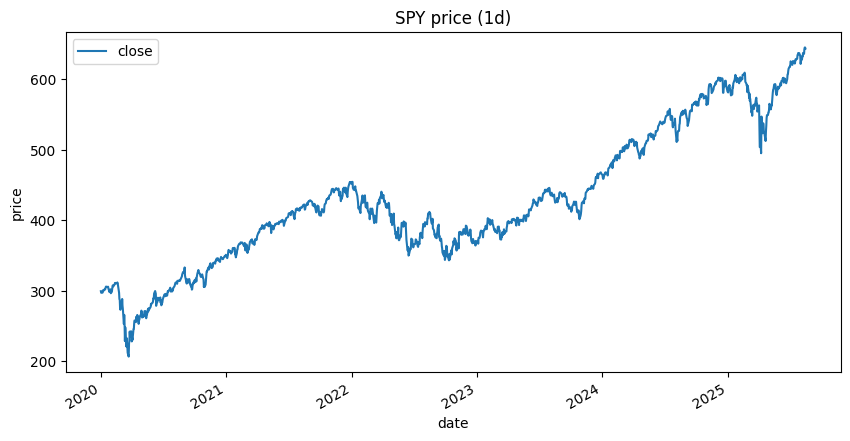

In [32]:
# Plot the closing price over time
ax = df.plot(
    x="timestamp",           # x-axis = time
    y="close",               # y-axis = closing price
    title=f"{symbol.upper()} price ({interval})",  # chart title
    figsize=(10,5)           # make chart bigger for readability
)

# Label the axes
ax.set_xlabel("date")
ax.set_ylabel("price")

# Show the chart
plt.show()

## 5) Returns: arithmetic vs log (why quants use log)

In [33]:
# --- Step 4: compute returns (arithmetic vs log) ---

# Arithmetic return: simple % change from one period to the next
df["return_arith"] = df["close"].pct_change()

# Log return: difference in natural logs of prices (additive over time, symmetric)
df["return_log"] = np.log(df["close"]).diff()

# Peek at the first few rows to compare
print(df[["timestamp", "close", "return_arith", "return_log"]].head(10))

                  timestamp       close  return_arith  return_log
0 2020-01-02 00:00:00+00:00  299.406433           NaN         NaN
1 2020-01-03 00:00:00+00:00  297.139252     -0.007572   -0.007601
2 2020-01-06 00:00:00+00:00  298.272797      0.003815    0.003808
3 2020-01-07 00:00:00+00:00  297.434204     -0.002811   -0.002815
4 2020-01-08 00:00:00+00:00  299.019379      0.005329    0.005315
5 2020-01-09 00:00:00+00:00  301.046936      0.006781    0.006758
6 2020-01-10 00:00:00+00:00  300.180573     -0.002878   -0.002882
7 2020-01-13 00:00:00+00:00  302.245117      0.006878    0.006854
8 2020-01-14 00:00:00+00:00  301.784332     -0.001525   -0.001526
9 2020-01-15 00:00:00+00:00  302.466217      0.002260    0.002257


## 6) Choose moving-average windows (short & long)

In [36]:
# --- Step 5: rolling statistics (trend & risk) ---

# --- choose moving-average window lengths interactively (with validation) ---

# guidance:
# - daily data common pairs: (20,100), (50,200)
# - shorter = more sensitive (more whipsaws), longer = smoother (fewer signals)

def get_int(prompt, default):
    """Ask for an integer; use default if blank."""
    s = input(f"{prompt} [default {default}]: ").strip()
    return default if s == "" else int(s)

# Suggest reasonable defaults for DAILY data
# Tip: for hourly data, multiply these by ~6–7; for weekly, divide by ~5
try:
    window_short = get_int("Enter SHORT MA window (days)", 20)   # ~1 trading month
    window_long  = get_int("Enter LONG  MA window (days)", 100)  # ~5 trading months

    # basic validation
    if window_short < 2:
        raise ValueError("Short window should be >= 2.")
    if window_long <= window_short:
        raise ValueError("Long window must be greater than short window.")

    print(f"Using MA windows: short={window_short}, long={window_long}")

except Exception as e:
    print("Invalid input:", e)
    print("Reverting to defaults: short=20, long=100")
    window_short, window_long = 20, 100

Enter SHORT MA window (days) [default 20]:  20
Enter LONG  MA window (days) [default 100]:  100


Using MA windows: short=20, long=100


## 7) Rolling stats: moving averages (trend) & volatility (risk)

In [37]:
# --- recompute rolling stats with chosen windows ---

# volatility = std of returns over the last N bars; *sqrt(PPY) to express as annualized risk (e.g., 0.20 = 20%/yr)

# Moving averages (trend)
df["ma_short"] = df["close"].rolling(window=window_short).mean()
df["ma_long"]  = df["close"].rolling(window=window_long).mean()

# Rolling volatility (risk) using short window; annualize by interval
ppy_map = {"1d": 252, "1wk": 52, "1mo": 12, "3mo": 4, "1h": 24*365, "60m": 24*365}
PPY = ppy_map.get(interval, 252)
df["volatility"] = df["return_log"].rolling(window=window_short).std() * np.sqrt(PPY)

## 8) Plot: price with MA_short & MA_long

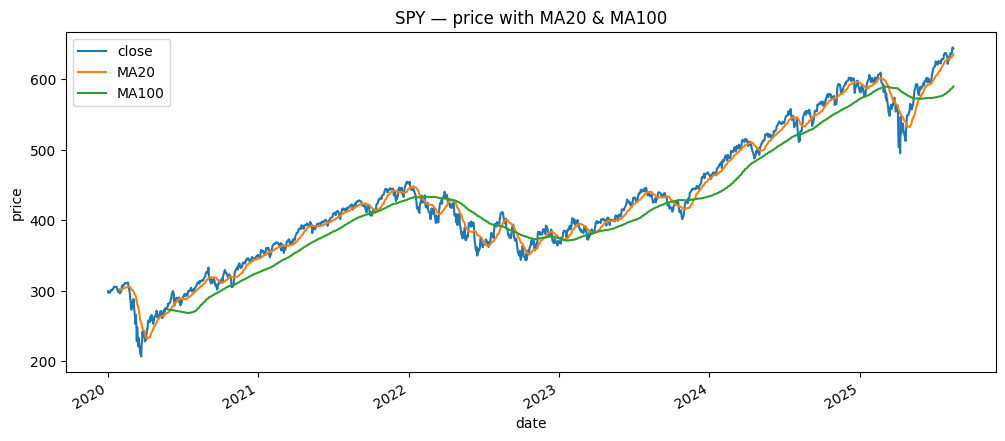

In [38]:
# --- Plot 1: price with moving averages (trend view) ---

# --- What to look for (Price + MAs) ---
# 1) When MA_short stays above MA_long for long stretches → persistent uptrend.
# 2) Crossovers (short crossing long) → potential entry/exit signals.
# 3) If MAs criss-cross constantly → choppy market; trend strategies struggle.

import matplotlib.pyplot as plt

ax = df.plot(
    x="timestamp",
    y="close",
    label="close",
    figsize=(12, 5),
    title=f"{symbol.upper()} — price with MA{window_short} & MA{window_long}"
)
df.plot(x="timestamp", y="ma_short", ax=ax, label=f"MA{window_short}")
df.plot(x="timestamp", y="ma_long",  ax=ax, label=f"MA{window_long}")
ax.set_xlabel("date")
ax.set_ylabel("price")
plt.show()

## 9) Plot: rolling volatility (annualized)

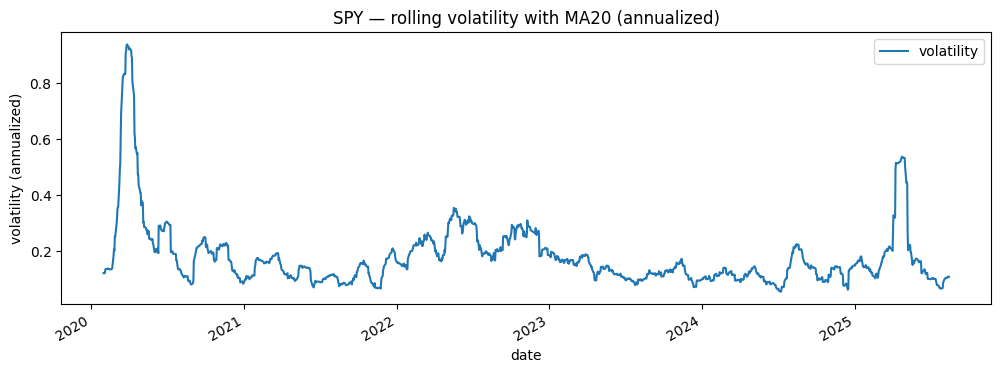

In [39]:
# --- Plot 2: rolling volatility (risk view) ---

# --- What to look for (Rolling Vol) ---
# 1) Spikes → crisis / regime change (expect bigger swings & whipsaws).
# 2) Low stable vol → calmer markets; MA signals may be cleaner.
# 3) Consider rules like "trade only when vol < threshold" or size positions by 1/vol.

"""
Volatility = standard deviation of returns.
- We compute it on log returns (ln(P_t) - ln(P_{t-1})) for nicer math.
- Use a rolling window to see how risk changes over time.
- Annualize by sqrt(periods_per_year) to make numbers comparable (e.g., 0.2 ~ 20%/yr).
What to watch:
- Smooth stretches (low vol) vs spikes (crises).
- Combine with MAs: trade trends when MA_short > MA_long and vol is reasonable.
"""

ax = df.plot(
    x="timestamp",
    y="volatility",
    figsize=(12, 4),
    title=f"{symbol.upper()} — rolling volatility with MA{window_short} (annualized)"
)
ax.set_xlabel("date")
ax.set_ylabel("volatility (annualized)")
plt.show()

## 10) Choose return basis for volatility ('log' recommended)

In [40]:
# --- Step X1: choose return basis for volatility (arith vs log) ---

import numpy as np

def choose_return_basis(default="log"):
    """Ask which return column to use for volatility calculations."""
    choice = input("Use 'log' or 'arith' returns for volatility? [default log]: ").strip().lower() or default
    if choice not in {"log", "arith"}:
        print("Invalid choice; falling back to 'log'.")
        choice = "log"

    # Ensure both return columns exist
    if "return_log" not in df.columns:
        df["return_log"] = np.log(df["close"]).diff()
    if "return_arith" not in df.columns:
        df["return_arith"] = df["close"].pct_change()

    ret_col = "return_log" if choice == "log" else "return_arith"
    print(f"Using {ret_col} for volatility.")
    return ret_col

RET_COL = choose_return_basis()

Use 'log' or 'arith' returns for volatility? [default log]:  arith


Using return_arith for volatility.


## 11) Fast vs slow volatility windows (+ annualization base)

In [41]:
# --- Step X2: choose TWO volatility windows (fast vs slow) and annualization base (PPY) ---

def get_int(prompt, default):
    """Input helper that accepts blank = default."""
    s = input(f"{prompt} [default {default}]: ").strip()
    return default if s == "" else int(s)

# pick windows (in bars of your current interval)
vol_fast = get_int("Enter FAST volatility window (bars)", 20)   # reacts quickly to regime changes
vol_slow = get_int("Enter SLOW volatility window (bars)", 60)   # smoother, shows background risk

# choose PPY (periods per year) based on your interval for annualization
ppy_map = {"1d": 252, "1wk": 52, "1mo": 12, "3mo": 4, "1h": 24*365, "60m": 24*365, "15m": 24*365*4}
PPY = ppy_map.get(interval, 252)
print(f"Annualizing with PPY={PPY} for interval='{interval}'")

# compute fast/slow vol using the chosen return basis
df[f"vol_fast_{vol_fast}"] = df[RET_COL].rolling(vol_fast).std() * np.sqrt(PPY)
df[f"vol_slow_{vol_slow}"] = df[RET_COL].rolling(vol_slow).std() * np.sqrt(PPY)

# show a few rows after windows fill (skip early NaNs)
start = max(vol_fast, vol_slow)
print(df.loc[start:start+5, ["timestamp", f"vol_fast_{vol_fast}", f"vol_slow_{vol_slow}"]])

Enter FAST volatility window (bars) [default 20]:  20
Enter SLOW volatility window (bars) [default 60]:  


Annualizing with PPY=252 for interval='1d'
                   timestamp  vol_fast_20  vol_slow_60
60 2020-03-30 00:00:00+00:00     0.925042     0.556765
61 2020-03-31 00:00:00+00:00     0.921940     0.557231
62 2020-04-01 00:00:00+00:00     0.913912     0.563621
63 2020-04-02 00:00:00+00:00     0.916812     0.566311
64 2020-04-03 00:00:00+00:00     0.916562     0.566461
65 2020-04-06 00:00:00+00:00     0.912414     0.584476


## 12) Plot: fast vs slow volatility (compare regimes)

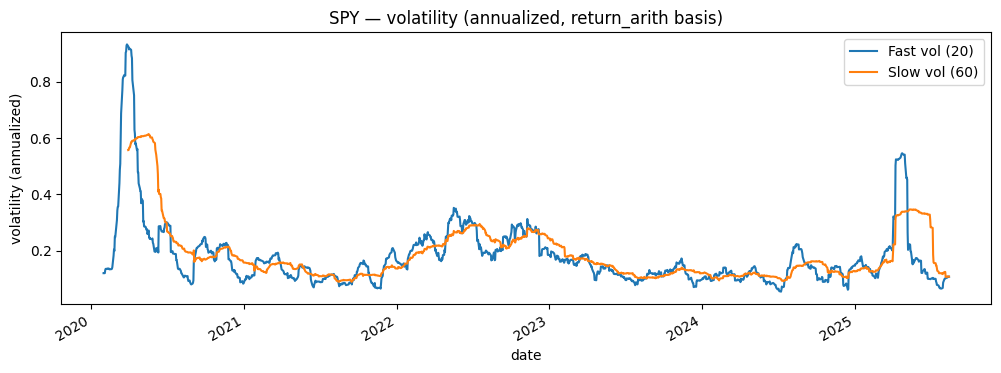

'\nReading this plot:\n- Fast vol spikes sooner → detects sudden turbulence quickly (useful for risk controls).\n- Slow vol moves gradually → background risk regime (useful for sizing or filters).\n- When fast >> slow, risk is rising; when fast < slow and falling, conditions are calming.\n'

In [42]:
# --- Step X3: plot fast vs slow volatility together (compare "fast risk" vs "slow risk") ---

import matplotlib.pyplot as plt

ax = df.plot(
    x="timestamp",
    y=f"vol_fast_{vol_fast}",
    figsize=(12, 4),
    label=f"Fast vol ({vol_fast})",
    title=f"{symbol.upper()} — volatility (annualized, {RET_COL} basis)"
)
df.plot(x="timestamp", y=f"vol_slow_{vol_slow}", ax=ax, label=f"Slow vol ({vol_slow})")
ax.set_xlabel("date"); ax.set_ylabel("volatility (annualized)")
plt.show()

"""
Reading this plot:
- Fast vol spikes sooner → detects sudden turbulence quickly (useful for risk controls).
- Slow vol moves gradually → background risk regime (useful for sizing or filters).
- When fast >> slow, risk is rising; when fast < slow and falling, conditions are calming.
"""

## 13) Threshold: mark high-vol regime (75th percentile)

High-volatility threshold (75th percentile of fast vol): 0.204


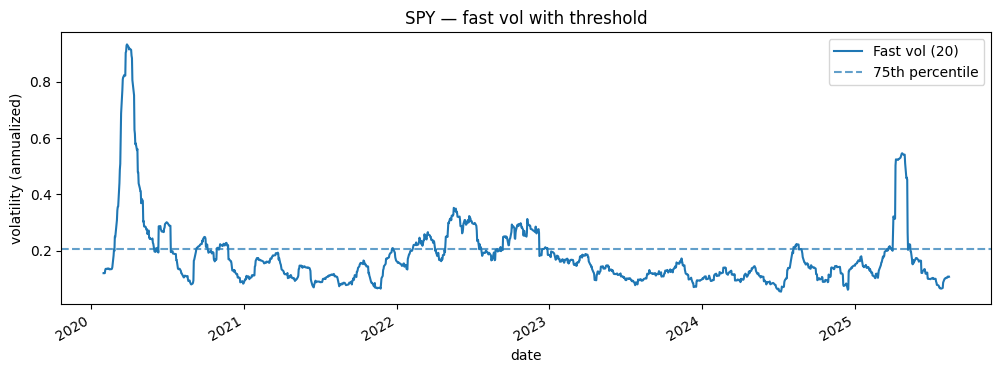

'\nWhy a threshold? \n- It gives you a simple rule-of-thumb boundary for "unusually risky" periods.\n- Later, you can test filters like: "only trade when fast_vol < threshold".\n'

In [43]:
# --- (Optional) Step X4: add a simple "high vol" threshold line for context ---

# choose a heuristic threshold, e.g., the 75th percentile of fast vol
thr = df[f"vol_fast_{vol_fast}"].quantile(0.75)
print(f"High-volatility threshold (75th percentile of fast vol): {thr:.3f}")

ax = df.plot(
    x="timestamp", y=f"vol_fast_{vol_fast}",
    figsize=(12,4), label=f"Fast vol ({vol_fast})",
    title=f"{symbol.upper()} — fast vol with threshold"
)
ax.axhline(thr, linestyle="--", label="75th percentile", alpha=0.7)
ax.set_xlabel("date"); ax.set_ylabel("volatility (annualized)")
ax.legend()
plt.show()

"""
Why a threshold? 
- It gives you a simple rule-of-thumb boundary for "unusually risky" periods.
- Later, you can test filters like: "only trade when fast_vol < threshold".
"""

## 14) Volatility summary stats (fast vs slow)

In [15]:
# --- Step X5: summarize volatility regimes numerically ---

summary = pd.DataFrame({
    "mean": [
        df[f"vol_fast_{vol_fast}"].mean(),
        df[f"vol_slow_{vol_slow}"].mean()
    ],
    "median": [
        df[f"vol_fast_{vol_fast}"].median(),
        df[f"vol_slow_{vol_slow}"].median()
    ],
    "95th_percentile": [
        df[f"vol_fast_{vol_fast}"].quantile(0.95),
        df[f"vol_slow_{vol_slow}"].quantile(0.95)
    ],
    "max": [
        df[f"vol_fast_{vol_fast}"].max(),
        df[f"vol_slow_{vol_slow}"].max()
    ]
}, index=[f"fast_{vol_fast}", f"slow_{vol_slow}"])

print("\n📊 Volatility summary (annualized):")
print(summary.round(3))


📊 Volatility summary (annualized):
          mean  median  95th_percentile   max
fast_34  0.263   0.238            0.453  0.91
slow_64  0.268   0.245            0.444  0.70


## 15) Shade high-volatility periods (visual regimes)

High-vol threshold = 0.300 (75th pct of fast vol)


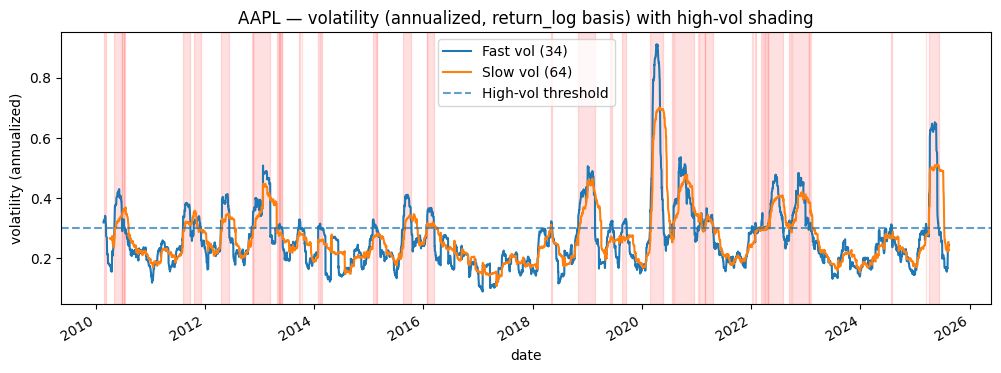

"\nReading this:\n- Red shading = periods where fast volatility exceeds the chosen threshold.\n- When shading is frequent/long, the market is in a turbulent regime.\n- You can later test filters like:\n    • Trade only when fast_vol < threshold\n    • Scale position size by 1 / fast_vol\nTuning:\n- Use a different percentile (e.g., 0.8/0.9) for a stricter definition of 'high vol'.\n- Or use an absolute cutoff if you know the asset (e.g., 0.35 = 35% annual vol).\n"

In [16]:
# --- Step X6: annotate high-volatility periods on the plot (shaded regions) ---

import numpy as np
import matplotlib.pyplot as plt

# 1) choose a threshold for "high vol" (you can tune the percentile)
thr = df[f"vol_fast_{vol_fast}"].quantile(0.75)   # 75th percentile
print(f"High-vol threshold = {thr:.3f} (75th pct of fast vol)")

# 2) boolean mask where fast vol is above the threshold
is_high = df[f"vol_fast_{vol_fast}"] > thr

# 3) find contiguous high-vol segments (start/end indices)
#    We look for transitions: False→True = start, True→False = end
high_idx = np.where(is_high.values)[0]
segments = []
if len(high_idx) > 0:
    # detect breaks where index jumps by more than 1 (separate segments)
    breaks = np.where(np.diff(high_idx) > 1)[0]
    starts = np.r_[high_idx[0], high_idx[breaks + 1]]
    ends   = np.r_[high_idx[breaks], high_idx[-1]]
    segments = list(zip(starts, ends))

# 4) plot fast/slow vol and shade high-vol spans
ax = df.plot(
    x="timestamp",
    y=f"vol_fast_{vol_fast}",
    figsize=(12, 4),
    label=f"Fast vol ({vol_fast})",
    title=f"{symbol.upper()} — volatility (annualized, {RET_COL} basis) with high-vol shading"
)
df.plot(x="timestamp", y=f"vol_slow_{vol_slow}", ax=ax, label=f"Slow vol ({vol_slow})")
ax.axhline(thr, linestyle="--", alpha=0.7, label="High-vol threshold")

# shade each high-vol span
for s, e in segments:
    x0 = df.loc[s, "timestamp"]
    x1 = df.loc[e, "timestamp"]
    ax.axvspan(x0, x1, color="red", alpha=0.12)  # light red shading

ax.set_xlabel("date")
ax.set_ylabel("volatility (annualized)")
ax.legend()
plt.show()

"""
Reading this:
- Red shading = periods where fast volatility exceeds the chosen threshold.
- When shading is frequent/long, the market is in a turbulent regime.
- You can later test filters like:
    • Trade only when fast_vol < threshold
    • Scale position size by 1 / fast_vol
Tuning:
- Use a different percentile (e.g., 0.8/0.9) for a stricter definition of 'high vol'.
- Or use an absolute cutoff if you know the asset (e.g., 0.35 = 35% annual vol).
"""

## 16) Regime view: low (blue) vs high (red) + binary signal

Low-vol threshold = 0.195, High-vol threshold = 0.300


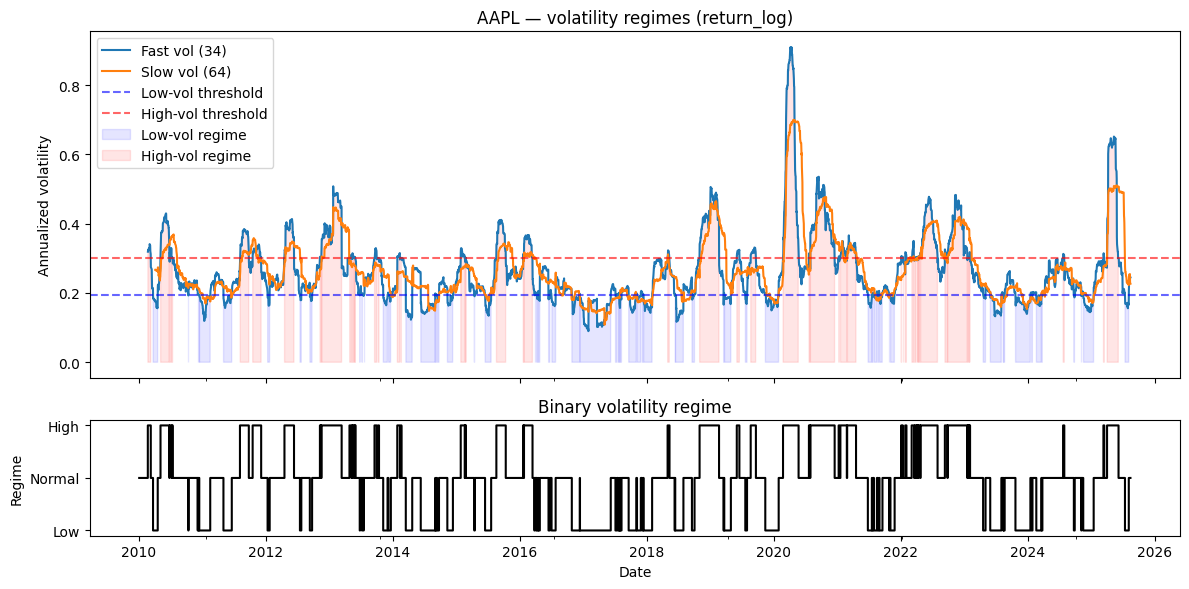

'\nInterpretation:\n- Top panel: you see vol bouncing around, with shaded calm (blue) vs turbulent (red) periods.\n- Bottom panel: a simple discrete signal (like a switch). This is what you can later feed into a backtest.\n    • -1 = calm → maybe increase exposure\n    •  0 = normal\n    • +1 = turbulent → maybe cut exposure or avoid trading\n'

In [17]:
# --- Step X7: visualize BOTH high- and low-volatility regimes ---

import matplotlib.pyplot as plt
import numpy as np

# thresholds: 25th percentile = "low vol", 75th percentile = "high vol"
low_thr  = df[f"vol_fast_{vol_fast}"].quantile(0.25)
high_thr = df[f"vol_fast_{vol_fast}"].quantile(0.75)

print(f"Low-vol threshold = {low_thr:.3f}, High-vol threshold = {high_thr:.3f}")

# masks
low_vol_mask  = df[f"vol_fast_{vol_fast}"] < low_thr
high_vol_mask = df[f"vol_fast_{vol_fast}"] > high_thr

# binary regime column (0=normal, 1=high, -1=low)
df["regime"] = 0
df.loc[high_vol_mask, "regime"] = 1
df.loc[low_vol_mask, "regime"]  = -1

# plot volatility with shading
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                               gridspec_kw={"height_ratios":[3,1]})

# top panel: volatility
df.plot(x="timestamp", y=f"vol_fast_{vol_fast}", ax=ax1, label=f"Fast vol ({vol_fast})")
df.plot(x="timestamp", y=f"vol_slow_{vol_slow}", ax=ax1, label=f"Slow vol ({vol_slow})")

ax1.axhline(low_thr, linestyle="--", color="blue", alpha=0.6, label="Low-vol threshold")
ax1.axhline(high_thr, linestyle="--", color="red", alpha=0.6, label="High-vol threshold")

# shading regimes
ax1.fill_between(df["timestamp"], 0, df[f"vol_fast_{vol_fast}"],
                 where=low_vol_mask, color="blue", alpha=0.1, label="Low-vol regime")
ax1.fill_between(df["timestamp"], 0, df[f"vol_fast_{vol_fast}"],
                 where=high_vol_mask, color="red", alpha=0.1, label="High-vol regime")

ax1.set_ylabel("Annualized volatility")
ax1.set_title(f"{symbol.upper()} — volatility regimes ({RET_COL})")
ax1.legend()

# bottom panel: binary regime
ax2.plot(df["timestamp"], df["regime"], drawstyle="steps-mid", color="black")
ax2.set_yticks([-1, 0, 1])
ax2.set_yticklabels(["Low", "Normal", "High"])
ax2.set_ylabel("Regime")
ax2.set_xlabel("Date")
ax2.set_title("Binary volatility regime")

plt.tight_layout()
plt.show()

"""
Interpretation:
- Top panel: you see vol bouncing around, with shaded calm (blue) vs turbulent (red) periods.
- Bottom panel: a simple discrete signal (like a switch). This is what you can later feed into a backtest.
    • -1 = calm → maybe increase exposure
    •  0 = normal
    • +1 = turbulent → maybe cut exposure or avoid trading
"""

## 17) Distribution of volatility (histogram + KDE + thresholds)

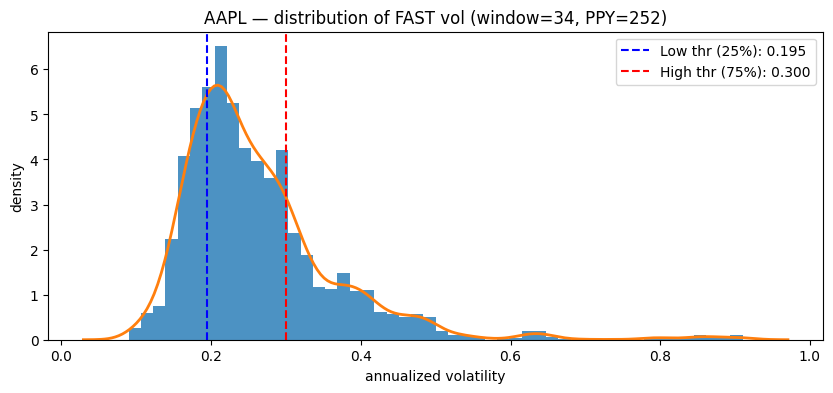

'\nReading this:\n- The histogram shows how often each volatility level occurs.\n- The dashed vertical lines mark the 25th and 75th percentiles used for low/high regimes.\n- Fat right tail → occasional very high volatility spikes (crisis periods).\n'

In [18]:
# --- Step V1: histogram of FAST volatility (annualized) with KDE & thresholds ---

import matplotlib.pyplot as plt

series = df[f"vol_fast_{vol_fast}"].dropna()

plt.figure(figsize=(10,4))
plt.hist(series, bins=50, alpha=0.8, density=True)   # density=True → area≈1; compares to KDE
try:
    # KDE curve (optional; requires scipy/statsmodels/seaborn; fallback if missing)
    import seaborn as sns
    sns.kdeplot(series, lw=2)
except Exception:
    pass

# draw low/high threshold lines
low_thr  = series.quantile(0.25)
high_thr = series.quantile(0.75)
plt.axvline(low_thr,  color="blue", ls="--", label=f"Low thr (25%): {low_thr:.3f}")
plt.axvline(high_thr, color="red",  ls="--", label=f"High thr (75%): {high_thr:.3f}")

plt.title(f"{symbol.upper()} — distribution of FAST vol (window={vol_fast}, PPY={PPY})")
plt.xlabel("annualized volatility")
plt.ylabel("density")
plt.legend()
plt.show()

"""
Reading this:
- The histogram shows how often each volatility level occurs.
- The dashed vertical lines mark the 25th and 75th percentiles used for low/high regimes.
- Fat right tail → occasional very high volatility spikes (crisis periods).
"""

## 18) Compare distributions: fast vs slow vol

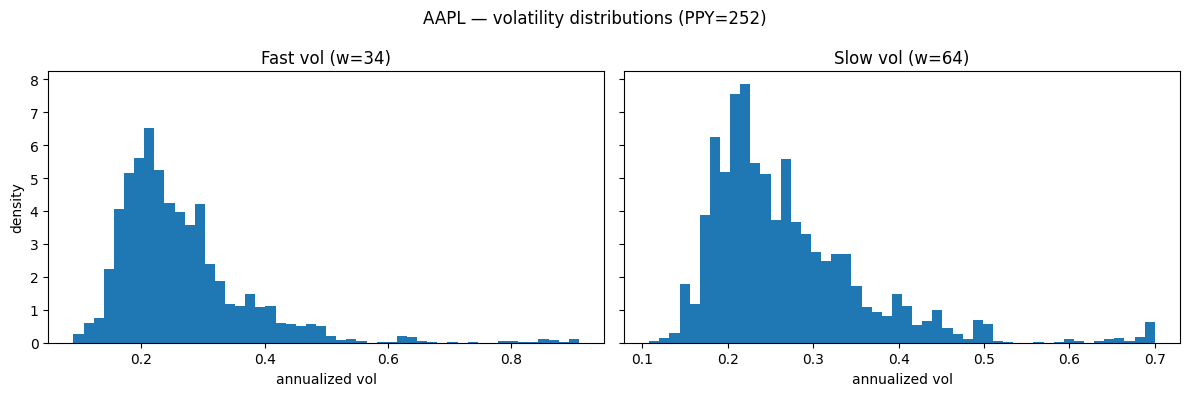

'\nReading this:\n- Fast vol peaks are broader and extend further right → reacts to shocks quickly.\n- Slow vol is tighter → reflects background risk regime.\n- If these look almost identical, your windows may be too similar; try (20 vs 60) or (20 vs 100).\n'

In [19]:
# --- Step V2: compare distributions of FAST vs SLOW volatility side by side ---

slow_series = df[f"vol_slow_{vol_slow}"].dropna()

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax[0].hist(series, bins=50, density=True)
ax[0].set_title(f"Fast vol (w={vol_fast})")
ax[0].set_xlabel("annualized vol"); ax[0].set_ylabel("density")

ax[1].hist(slow_series, bins=50, density=True)
ax[1].set_title(f"Slow vol (w={vol_slow})")
ax[1].set_xlabel("annualized vol")

plt.suptitle(f"{symbol.upper()} — volatility distributions (PPY={PPY})")
plt.tight_layout()
plt.show()

"""
Reading this:
- Fast vol peaks are broader and extend further right → reacts to shocks quickly.
- Slow vol is tighter → reflects background risk regime.
- If these look almost identical, your windows may be too similar; try (20 vs 60) or (20 vs 100).
"""

## 19) Coverage: % of time in each regime (low/normal/high)

In [20]:
# --- Step V3: numeric summary & regime coverage (how often are we in each regime?) ---

import pandas as pd

fast = df[f"vol_fast_{vol_fast}"]

stats = pd.DataFrame({
    "fast_mean":   [fast.mean()],
    "fast_median": [fast.median()],
    "fast_95p":    [fast.quantile(0.95)],
    "slow_mean":   [slow_series.mean()],
    "slow_median": [slow_series.median()],
    "slow_95p":    [slow_series.quantile(0.95)],
}).round(3)

# recompute thresholds for clarity
low_thr  = fast.quantile(0.25)
high_thr = fast.quantile(0.75)
share_low  = (fast < low_thr).mean()
share_high = (fast > high_thr).mean()
share_mid  = 1 - share_low - share_high

print("📊 Vol summary (annualized):")
print(stats)
print(f"\nRegime coverage based on FAST vol:")
print(f"  Low (<25th):  {share_low*100:.1f}%")
print(f"  Normal:       {share_mid*100:.1f}%")
print(f"  High (>75th): {share_high*100:.1f}%")

"""
Why this matters:
- Coverage tells you how many days a 'filter' would block trades (e.g., avoid top 25% high-vol days).
- If 'High' is tiny (e.g., <5%), your threshold might be too strict; if it's huge (>40%), too loose.
"""

📊 Vol summary (annualized):
   fast_mean  fast_median  fast_95p  slow_mean  slow_median  slow_95p
0      0.263        0.238     0.453      0.268        0.245     0.444

Regime coverage based on FAST vol:
  Low (<25th):  24.8%
  Normal:       50.4%
  High (>75th): 24.8%


"\nWhy this matters:\n- Coverage tells you how many days a 'filter' would block trades (e.g., avoid top 25% high-vol days).\n- If 'High' is tiny (e.g., <5%), your threshold might be too strict; if it's huge (>40%), too loose.\n"

## 20) Volatility histogram with log x-axis (tail emphasis)

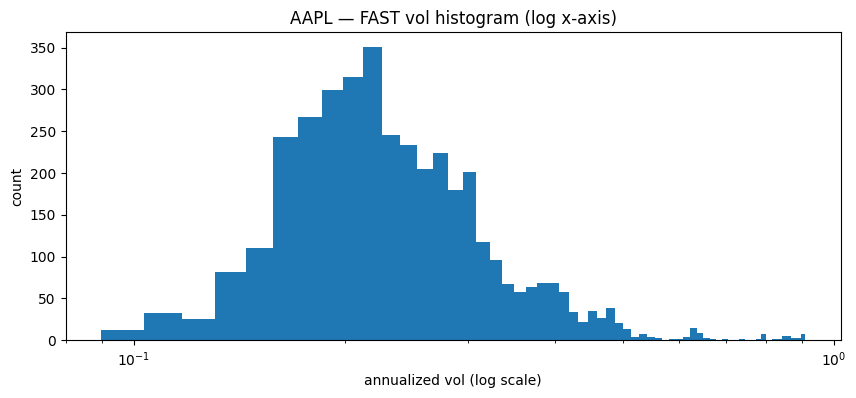

'\nUse log-scale when volatility has a long right tail (many small values, few very large spikes).\nIt helps you visualize extreme risk events that are otherwise squished.\n'

In [21]:
# --- Step V4 (optional): log-scale x-axis for long right tails ---

plt.figure(figsize=(10,4))
plt.hist(series, bins=60)
plt.xscale("log")  # log scale shows tail behavior more clearly
plt.title(f"{symbol.upper()} — FAST vol histogram (log x-axis)")
plt.xlabel("annualized vol (log scale)")
plt.ylabel("count")
plt.show()

"""
Use log-scale when volatility has a long right tail (many small values, few very large spikes).
It helps you visualize extreme risk events that are otherwise squished.
"""

## 21) (Optional) Distribution of arithmetic returns

missing in return_arith: 1 | missing in return_log: 1


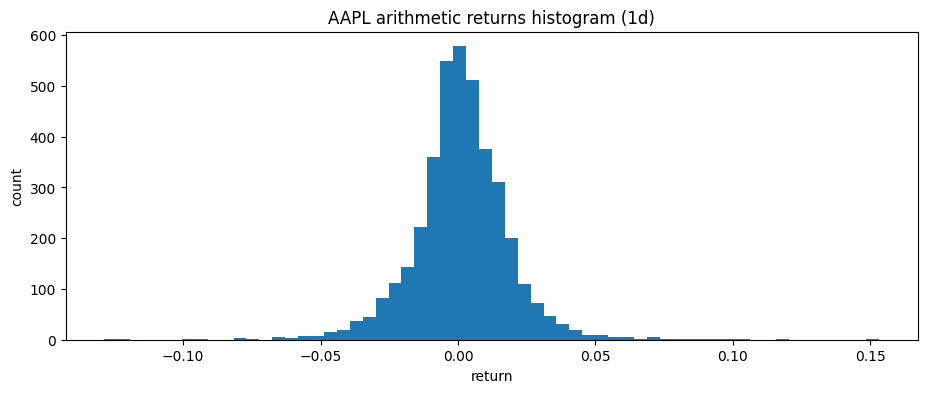

In [22]:
# --- Extra: return distribution quick view (optional) ---

print("missing in return_arith:", df["return_arith"].isna().sum(),
      "| missing in return_log:", df["return_log"].isna().sum())

rets = df["return_arith"].dropna()
log_rets = df["return_log"].dropna()

plt.hist(rets, bins=60)
plt.title(f"{symbol.upper()} arithmetic returns histogram ({interval})")
plt.xlabel("return"); plt.ylabel("count")
plt.show()

In [ ]:
# --- Extra: return distribution quick view (optional) ---

print("missing in return_arith:", df["return_arith"].isna().sum(),
      "| missing in return_log:", df["return_log"].isna().sum())

rets = df["return_arith"].dropna()
log_rets = df["return_log"].dropna()

plt.hist(rets, bins=60)
plt.title(f"{symbol.upper()} arithmetic returns histogram ({interval})")
plt.xlabel("return"); plt.ylabel("count")
plt.show()

## 22) (Optional) Save processed dataset (with returns, MAs, volatility)

In [ ]:
proc_dir = Path("../data/processed")
proc_dir.mkdir(parents=True, exist_ok=True)

# build a tidy filename that mirrors raw
if maybe_start and maybe_end:
    out_proc = proc_dir / f"{symbol}_{interval}_{maybe_start}_{maybe_end}_yf_proc.csv"
else:
    out_proc = proc_dir / f"{symbol}_{interval}_yf_proc.csv"

df.to_csv(out_proc, index=False)
print("saved:", out_proc)